In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1)

In [2]:
DATA_PATH = "data/"
TRAIN_DATA_FILE = "exoTrainData_upsampled.npy"
TRAIN_LABELS_FILE = "exoTrainLabels_upsampled.npy"
TEST_DATA_FILE = "exoTestData.npy"
TEST_LABELS_FILE = "exoTestLabels.npy"

x_train = np.load("{}{}".format(DATA_PATH, TRAIN_DATA_FILE))
y_train = np.load("{}{}".format(DATA_PATH, TRAIN_LABELS_FILE))
x_test = np.load("{}{}".format(DATA_PATH, TEST_DATA_FILE))
y_test = np.load("{}{}".format(DATA_PATH, TEST_LABELS_FILE))

# TODO: actually get this in some time units so can set autopower arg more legitimately
t = np.arange(x_train.shape[1])

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10082, 3197)
(10082,)
(570, 3197)
(570,)


# Box Least Squares

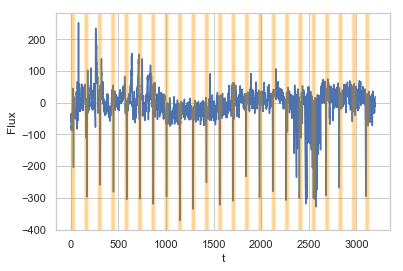

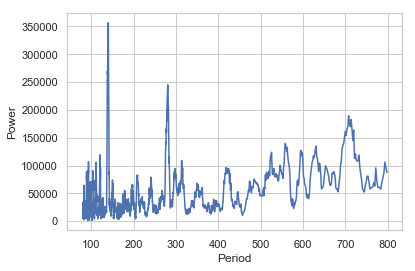

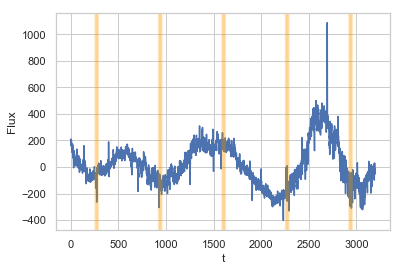

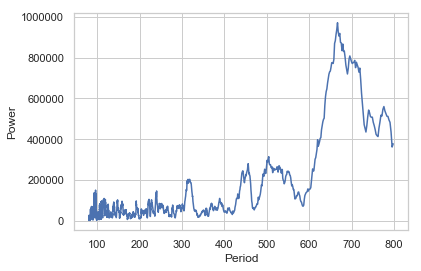

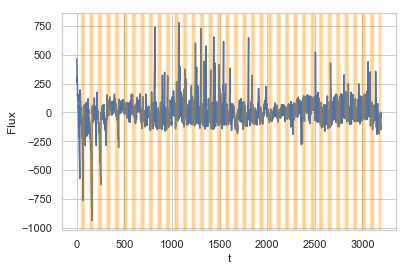

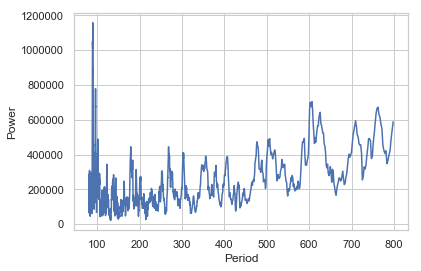

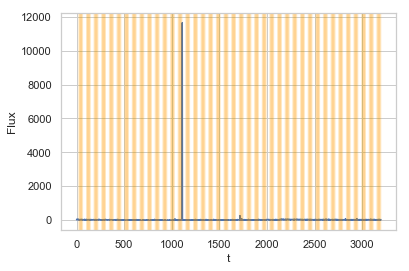

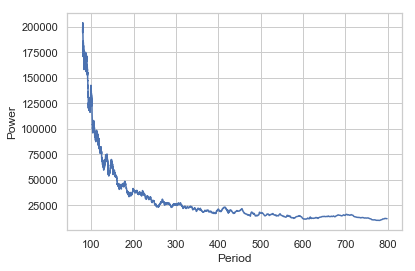

In [21]:
from astropy.stats import BoxLeastSquares

for i in [1, 5, 70, 71]:
    bls = BoxLeastSquares(t, x_train[i])
    periodogram = bls.autopower(40, minimum_n_transit=5)  # arg is the granularity of considered durations
    max_power = np.argmax(periodogram.power)
    mask = bls.transit_mask(t,
                            periodogram.period[max_power],
                            periodogram.duration[max_power],
                            periodogram.transit_time[max_power])
    
    plt.plot(t, x_train[i])
    plt.xlabel("t")
    plt.ylabel("Flux")
    for ti in np.nonzero(mask)[0]:
        plt.axvline(ti, color="orange", alpha=0.03)
    plt.show()
    
    plt.plot(periodogram.period, periodogram.power)
    plt.xlabel("Period")
    plt.ylabel("Power")
    plt.show()

In [29]:
from sklearn import metrics

def compute_metrics(clf, x_train, y_train, x_test, y_test):
    print("Accuracy on training data:", clf.score(x_train, y_train))
    print("Accuracy on test data:", clf.score(x_test, y_test))
    test_predicted_probs = clf.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, test_predicted_probs)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    print("AUC:", metrics.auc(fpr, tpr))
    test_predicted = clf.predict(x_test)
    print("F1:", metrics.f1_score(y_test, test_predicted))
    print("Test prediction frequencies:")
    print(np.unique(test_predicted, return_counts=True))
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y_test, test_predicted))
    print()

def compute_metrics_from_predictions(y_true, y_pred, y_pred_score=None):
    print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
    if y_pred_score is not None:
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_score)
        print("Threshold range:", thresholds.min(), thresholds.max())
        plt.plot(fpr, tpr)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()
        print("AUC:", metrics.auc(fpr, tpr))
    print("F1:", metrics.f1_score(y_true, y_pred))
    print("Test prediction frequencies:")
    print(np.unique(y_pred, return_counts=True))
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y_true, y_pred))
    print()

In [11]:
from astropy.stats import BoxLeastSquares

def get_bls_snr(x):
    snrs = []
    for i in range(x.shape[0]):
        bls = BoxLeastSquares(t, x[i])
        periodogram = bls.autopower(40, minimum_n_transit=5, objective="snr")  # arg is the granularity of considered durations
        # based on https://arxiv.org/pdf/astro-ph/0206099.pdf
        snrs.append(np.max(periodogram.depth_snr))
        if (i + 1) % 10 == 0:
            print(".", end="")
        if (i + 1) % 500 == 0:
            print()
    print()
    return np.array(snrs).reshape((-1, 1))

In [12]:
%%time

bls_snr_train = get_bls_snr(x_train)

..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
...............................

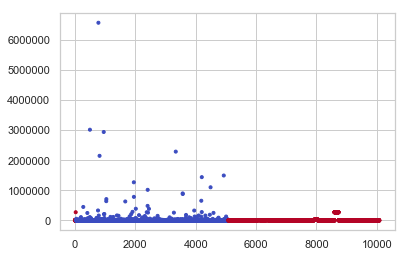

11.111210503438318
6566940.626268538


In [28]:
plt.scatter(np.arange(bls_snr_train.shape[0]), bls_snr_train.flatten(), marker='.', c=y_train, cmap="coolwarm")
plt.show()
print(bls_snr_train.min())
print(bls_snr_train.max())

Accuracy: 0.508926800238048
Threshold range: 11.111210503438318 6566941.626268538


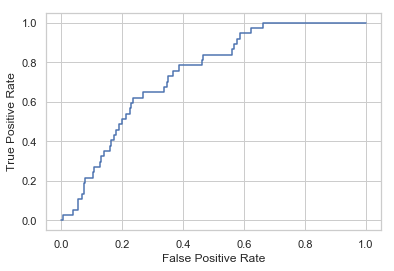

AUC: 0.7413486754080814
F1: 0.052077350181887805
Test prediction frequencies:
(array([False,  True]), array([9891,  191], dtype=int64))
Confusion matrix:
[[4995   55]
 [4896  136]]



In [38]:
bls_snr_train_pred = bls_snr_train > 1e5
compute_metrics_from_predictions(y_train, bls_snr_train_pred, bls_snr_train)
# TODO: run this on non-upsampled data, and determine threshold that still finds all exoplanets

In [22]:
bls_snr_test = get_bls_snr(x_test)

..................................................
.......


Accuracy: 0.4473684210526316
Threshold range: 27.76464588333404 1385173.567620469


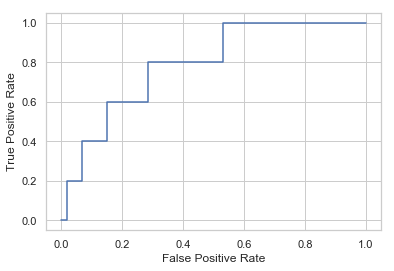

AUC: 0.7900884955752212
F1: 0.03076923076923077
Test prediction frequencies:
(array([False,  True]), array([250, 320], dtype=int64))
Confusion matrix:
[[250 315]
 [  0   5]]



In [46]:
bls_snr_test_pred = bls_snr_test > 2e2
compute_metrics_from_predictions(y_test, bls_snr_test_pred, bls_snr_test)

Accuracy on training data: 0.4991073199761952
Accuracy on test data: 0.008771929824561403


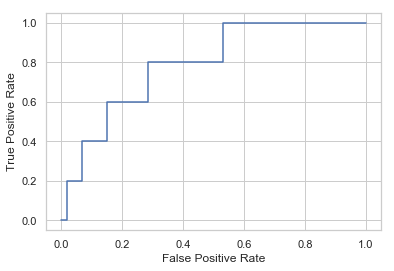

AUC: 0.7900884955752212
F1: 0.017391304347826087
Test prediction frequencies:
(array([1.]), array([570], dtype=int64))
Confusion matrix:
[[  0 565]
 [  0   5]]



In [23]:
compute_metrics(bls_snr_logit, bls_snr_train, y_train, bls_snr_test, y_test)

In [27]:
from astropy.stats import BoxLeastSquares

stat_names = ["depth", "depth_odd", "depth_even", "depth_half", "depth_phased"]

def get_bls_features(x):
    features = []
    for i in range(x.shape[0]):
        # adapted from http://docs.astropy.org/en/stable/stats/bls.html#peak-statistics
        bls = BoxLeastSquares(t, x[i])
        periodogram = bls.autopower(40, minimum_n_transit=5)  # arg is the granularity of considered durations
        max_power = np.argmax(periodogram.power)
        stats = bls.compute_stats(periodogram.period[max_power],
                                  periodogram.duration[max_power],
                                  periodogram.transit_time[max_power])
        features.append([stats[s][0] / stats[s][1] for s in stat_names])
        features[-1].extend([stats[s][0] for s in stat_names])
        features[-1].extend([stats[s][1] for s in stat_names])
        features[-1].append(periodogram.power[max_power])
        features[-1].append(periodogram.period[max_power])
        features[-1].append(periodogram.duration[max_power])
        features[-1].append(periodogram.transit_time[max_power])
        if (i + 1) % 10 == 0:
            print(".", end="")
        if (i + 1) % 500 == 0:
            print()
    print()
    return np.array(features)

In [28]:
%%time

bls_train_features = get_bls_features(x_train)

..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
...............................

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
bls_train_features = scaler.fit_transform(bls_train_features)

In [30]:
from sklearn.linear_model import LogisticRegression

bls_logit = LogisticRegression()
bls_logit.fit(bls_train_features, y_train)

C:\Users\czhao\Miniconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
print(bls_logit.coef_)
# print(bls_train_ratios.min(), bls_train_ratios.max())
# print("Ratio decision boundary:", -bls_logit.intercept_ / bls_logit.coef_)

# TODO: plot data with decision boundary

[[-1.81921332 -1.22203015  1.05175055 -1.14932119  2.13713135 -1.53740533
   2.96174016  3.44799447 -1.44076164 -1.18838177  0.6786882   1.12319016
  -1.35061195 -4.98194214  3.08484713 -4.11789262 -0.75828873  0.
   0.05495807]]


In [32]:
bls_test_features = get_bls_features(x_test)

..................................................
.......


In [33]:
bls_test_features = scaler.transform(bls_test_features)

In [34]:
bls_logit.predict_proba(bls_test_features[:10])

array([[0.45397919, 0.54602081],
       [0.35530066, 0.64469934],
       [0.31435236, 0.68564764],
       [0.43845472, 0.56154528],
       [0.35598771, 0.64401229],
       [0.7491716 , 0.2508284 ],
       [0.85934429, 0.14065571],
       [0.61798716, 0.38201284],
       [0.57368765, 0.42631235],
       [0.72889319, 0.27110681]])

In [36]:
np.save("bls_train.npy", bls_train_features)
np.save("bls_test.npy", bls_test_features)

Accuracy on training data: 0.6710970045625868
Accuracy on test data: 0.6491228070175439


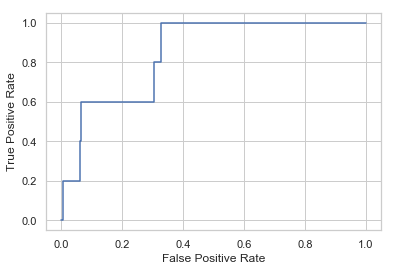

AUC: 0.847433628318584
F1: 0.047619047619047616
Test prediction frequencies:
(array([0., 1.]), array([365, 205], dtype=int64))
Confusion matrix:
[[365 200]
 [  0   5]]



In [35]:
compute_metrics(bls_logit, bls_train_features, y_train, bls_test_features, y_test)

# LSTM

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, CuDNNLSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
#     LSTM(16, input_shape=(x_train.shape[1], 1), dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(16)),
#     tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(3e-4), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.FalseNegatives()])
x_train_lstm = x_train[:, :, np.newaxis]
y_train_lstm = y_train
x_test_lstm = x_test[:, :, np.newaxis]
y_test_lstm = y_test
train_accuracies = []
test_accuracies = []

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
%%time

N_EPOCHS = 5
BATCH_SIZE = 32

hist = model.fit(x_train_lstm, y_train_lstm, validation_data=(x_test_lstm, y_test_lstm), epochs=N_EPOCHS, batch_size=BATCH_SIZE)
train_accuracies.extend(hist.history["acc"])
test_accuracies.extend(hist.history["val_acc"])

Train on 10082 samples, validate on 570 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
10082/10082 [==============================] - 192s 19ms/sample - loss: 0.3871 - acc: 0.8299 - false_negatives: 416.0000 - val_loss: 0.2071 - val_acc: 0.9246 - val_false_negatives: 5.0000
Epoch 2/5
10082/10082 [==============================] - 189s 19ms/sample - loss: 0.1507 - acc: 0.9607 - false_negatives: 72.0000 - val_loss: 0.1731 - val_acc: 0.9298 - val_false_negatives: 5.0000
Epoch 3/5
10082/10082 [==============================] - 190s 19ms/sample - loss: 0.1049 - acc: 0.9707 - false_negatives: 57.0000 - val_loss: 0.1962 - val_acc: 0.9263 - val_false_negatives: 5.0000
Epoch 4/5
10082/10082 [==============================] - 190s 19ms/sample - loss: 0.0725 - acc: 0.9822 - false_negatives: 16.0000 - val_loss: 0.1729 - val_acc: 0.9456 - val_false_negatives: 5.0000
Epoch 5/5
10082/10082 [==============================] - 189s 19ms/sample - loss: 0.0767 - acc: 0.9794 - false_nega

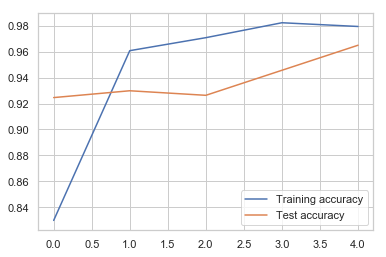

In [5]:
plt.plot(train_accuracies, label="Training accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.legend()
plt.show()

In [10]:
lstm_test_preds = model.predict(x_test_lstm)

In [11]:
lstm_test_preds

array([[1.99037075e-01],
       [1.98841989e-02],
       [2.17452645e-03],
       [3.75092030e-04],
       [5.76436520e-04],
       [1.46743655e-03],
       [1.50864422e-02],
       [3.90708447e-04],
       [1.13176048e-01],
       [1.48726106e-02],
       [6.29716218e-02],
       [1.68928891e-01],
       [7.38114119e-04],
       [4.25391495e-02],
       [1.21299028e-02],
       [9.71525908e-04],
       [3.13095152e-02],
       [6.36845827e-04],
       [7.04139471e-04],
       [1.06739998e-03],
       [8.04245472e-04],
       [4.36935425e-02],
       [5.48779964e-04],
       [3.43054533e-04],
       [7.04920292e-03],
       [8.19683075e-04],
       [4.99904156e-04],
       [3.50147486e-04],
       [1.69128180e-02],
       [2.31777430e-02],
       [1.74356997e-02],
       [9.26494598e-04],
       [6.82383776e-04],
       [7.77060091e-02],
       [5.00234962e-03],
       [9.19938087e-03],
       [1.06118917e-02],
       [3.44566703e-02],
       [1.10247731e-03],
       [5.03450632e-04],
